# Consumo de gas en Punta Arenas (Python)
---

1.- [Explorar datos](#explore)
&nbsp;

2.- [Pre-procesamiento](#pre)
&nbsp;

3.- [Modelar datos](#model)

&nbsp;
    3.1.- [Random Forest](#rf)

&nbsp;
    3.2.- [Support Vector Regression](#svr)
    
&nbsp;
    3.3.- [Decision Trees](#dl)
&nbsp;

4.- [Análisis y evaluación de los modelos](#anal)
&nbsp;

## 1.- Explorar datos
<a id="explore"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

Primero se importa el conjunto de datos y se imprimen los primeros ejemplares para observar su naturaleza.

In [2]:
gasConsume = pd.read_csv('gasConsume.csv', sep=";")
gasConsume.head()

,Consumo,Dia,Mes,A�o,DiaSemana,Feriado
0,716,20,10,1995,Viernes,0
1,605,21,10,1995,S�bado,1
2,555,22,10,1995,Domingo,1
3,680,23,10,1995,Lunes,0
4,713,24,10,1995,Martes,0


In [3]:
gasConsume.columns = ['Consumo', 'Dia','Mes','Ano','DiaSemana','Feriado']
gasConsume.head(1)

,Consumo,Dia,Mes,Ano,DiaSemana,Feriado
0,716,20,10,1995,Viernes,0


In [4]:
gasConsume.describe()

,Consumo,Dia,Mes,Ano,Feriado
count,2630.000000,2630.000000,2630.000000,2630.000000,2630.000000
mean,725.563118,15.776046,6.653992,1998.888213,0.198099
std,171.770851,8.810094,3.491289,2.079180,0.398643
min,333.000000,1.000000,1.000000,1995.000000,0.000000
25%,579.000000,8.000000,4.000000,1997.000000,0.000000
50%,715.000000,16.000000,7.000000,1999.000000,0.000000
75%,876.000000,23.000000,10.000000,2001.000000,0.000000
max,1222.000000,31.000000,12.000000,2002.000000,1.000000


Se puede observar que los datos corresponden a dias, meses y años, un indicador de feriados y por cada fechala magnitud del consumo de gas en valores contiuos.Luego se realizan visualizaciones para estudiar de forma preliminar el comportamiento de los datos.

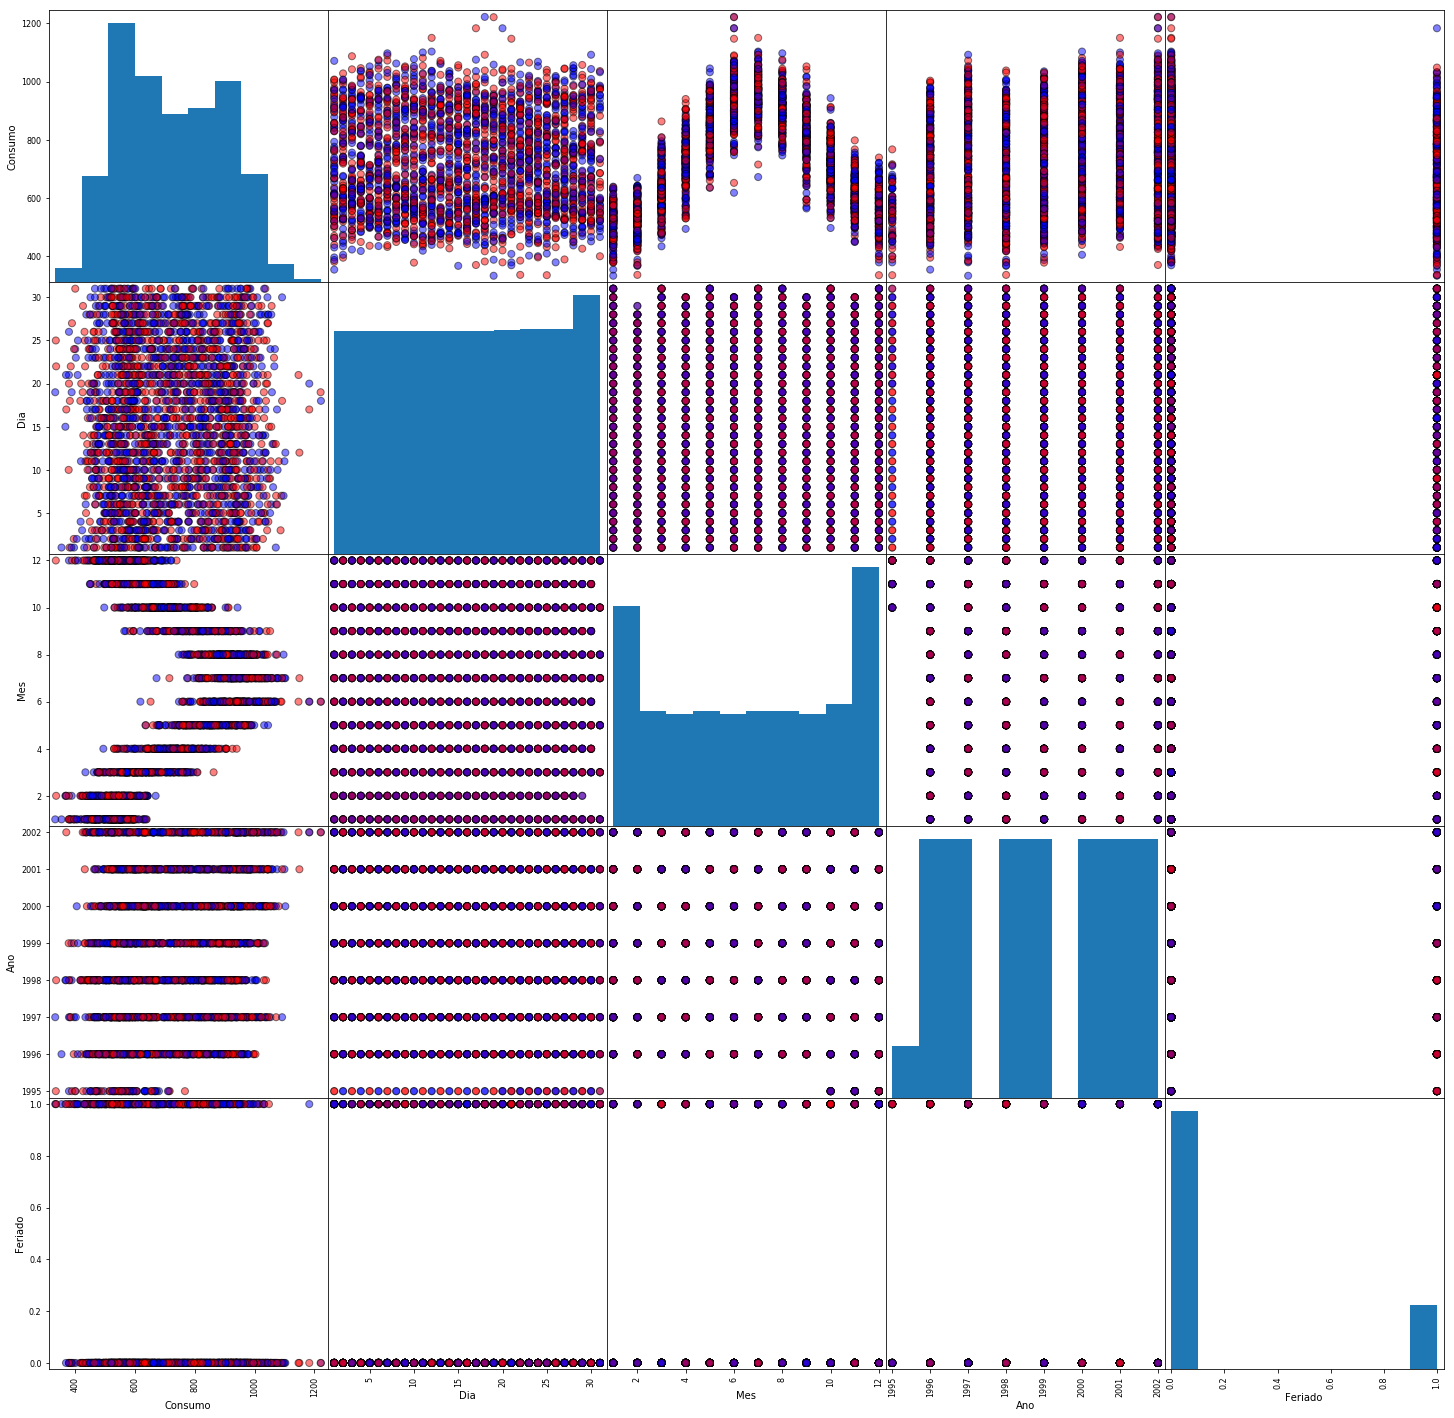

In [5]:
pd.plotting.scatter_matrix(
    gasConsume.loc[0:,gasConsume.columns],c=['red','blue'],alpha=0.5,
    figsize=[25,25],diagonal='hist',s=200,marker='.',edgecolor='black')
plt.show()

Text(0,0.5,'Consumo')

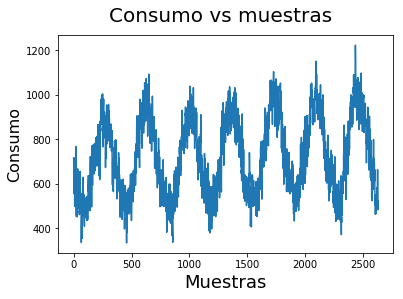

In [78]:
plt.plot(gasConsume["Consumo"])
plt.suptitle('Consumo vs muestras', fontsize=20)
plt.xlabel('Muestras', fontsize=18)
plt.ylabel('Consumo', fontsize=16)

Se puede apreciar en este gráfico que existe cierto periodo a través de los años en cuanto al consumo de gas.

Text(0,0.5,'Muestras')

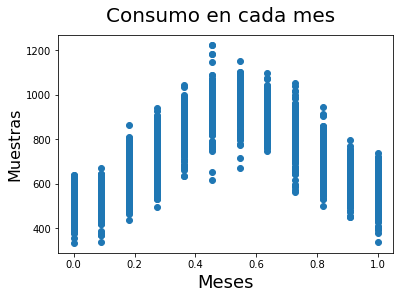

In [79]:
plt.plot(gasConsume["Mes"],gasConsume["Consumo"], 'o')
plt.suptitle('Consumo en cada mes', fontsize=20)
plt.xlabel('Meses', fontsize=18)
plt.ylabel('Muestras', fontsize=16)

Los rangos de valores de gas consumido son claramente superiores en algunos meses, aún así van desde las 200
a 400 unidades aproximadamente por lo que sería imposible predecir de esta forma el consumo para un día en específico

Para modelar la forma en que el consumo varía dependiendo basándose en estas variables se debe crear un modelo de regresión. Sin embargo los datos no se encuentran en la forma apropiada para ser modelados de la mejor manera. Por esto se realizara una fase de pre-procesamiento para transformar los datos y obtener los conjuntos de entrenamiento y prueba.

## 2.- Pre-procesamiento
<a id="pre"></a>

Antes de entrenar el modelo es recomendable utilizar el proceso one-hot encoding. Como el conjunto de datos posee valores categórico (los días de semana), lo adecuado es pasarlo a valores numéricos para facilitar el aprendizaje del algoritmo. Una solución podría ser renombrar esta variable con valores del 1 al 7 para  representar los días, pero esto podría conducir a que el algoritmo le de mayor peso al Domingo por ser el  número 7 que al Lunes por ser el 1, por lo tanto es recomendable convertir esta variable en una matriz de datos binarios.

In [8]:
gasConsume = pd.get_dummies(gasConsume)
gasConsume.head()

,Consumo,Dia,Mes,Ano,Feriado,DiaSemana_Domingo,DiaSemana_Jueves,DiaSemana_Lunes,DiaSemana_Martes,DiaSemana_Mi�rcoles,DiaSemana_S�bado,DiaSemana_Viernes
0,716,20,10,1995,0,0,0,0,0,0,0,1
1,605,21,10,1995,1,0,0,0,0,0,1,0
2,555,22,10,1995,1,1,0,0,0,0,0,0
3,680,23,10,1995,0,0,0,1,0,0,0,0
4,713,24,10,1995,0,0,0,0,1,0,0,0


Se puede apreciar como se crea una columna por cada valor categórico encontrado

Luego es recomendable escalar los datos ya que poseen diversas escalas de magnitudes en las columnas lo que provocará que algunos tengan mayor influencia sobre el modelo. Para esto se crea una pequeña función que dejará a las características en rangos de 0 a 1 (no es necesario hacer eso con la variable que se intenta predecir)

In [9]:
def normalized(x):
    normalData =(x-min(x))/(max(x)-min(x))
    return normalData

In [10]:
gasConsume["Dia"] = normalized(gasConsume["Dia"])
gasConsume["Mes"] = normalized(gasConsume["Mes"])
gasConsume["Ano"] = normalized(gasConsume["Ano"])
gasConsume.head()

,Consumo,Dia,Mes,Ano,Feriado,DiaSemana_Domingo,DiaSemana_Jueves,DiaSemana_Lunes,DiaSemana_Martes,DiaSemana_Mi�rcoles,DiaSemana_S�bado,DiaSemana_Viernes
0,716,0.633333,0.818182,0.0,0,0,0,0,0,0,0,1
1,605,0.666667,0.818182,0.0,1,0,0,0,0,0,1,0
2,555,0.700000,0.818182,0.0,1,1,0,0,0,0,0,0
3,680,0.733333,0.818182,0.0,0,0,0,1,0,0,0,0
4,713,0.766667,0.818182,0.0,0,0,0,0,1,0,0,0


Se separan los conjuntos de variables predictoras o características (features) y objetivos (labels)

In [11]:
labels = np.array(gasConsume['Consumo'])

In [12]:
features = gasConsume.drop('Consumo', axis = 1)

In [13]:
feature_list = list(features.columns)
features = np.array(features)

Se importa el módulo para obtener los conjuntos de entrenamiento y prueba. Estos se obtienen de forma aleatoria y se utiliza el número de semilla 42 para asegurar la reproducción de las pruebas.

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size = 0.25, random_state = 42)

El conjunto de entrenamiento corresponde al 75% de la muestra. Este tamaño resulta apropiado para que el conjunto de test posea datos suficientes a lo largo de cada mes del año para predecir

In [90]:
train_features = pd.DataFrame(train_features)
test_features = pd.DataFrame(test_features)
train_features.columns = feature_list
test_features.columns = feature_list

In [17]:
train_features.head()

,Dia,Mes,Ano,Feriado,DiaSemana_Domingo,DiaSemana_Jueves,DiaSemana_Lunes,DiaSemana_Martes,DiaSemana_Mi�rcoles,DiaSemana_S�bado,DiaSemana_Viernes
0,0.133333,0.818182,0.571429,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.466667,0.818182,0.571429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.733333,0.545455,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.000000,0.636364,0.857143,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.100000,0.818182,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [18]:
import seaborn as sns

Se realizan algunos gráficos de densidad para comprobar que los datos poseen distribuciónes similares

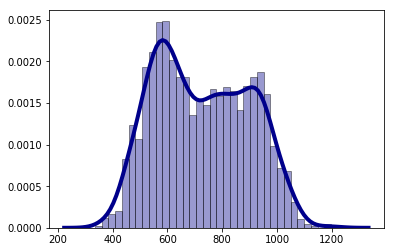

In [19]:
sns.distplot(train_labels, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

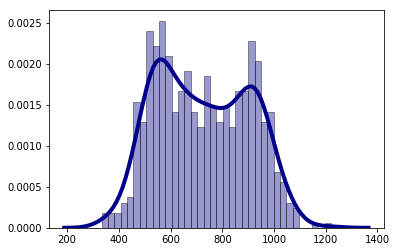

In [20]:
sns.distplot(test_labels, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

Además vale la pena probar que la distribución de los datos no poseen diferencias significativas. En caso de ser datos normales se puede recurrir al test de t-student, de otra forma al de Wilcox-Mann Whitney. Para probar la normalidad se usa el test de Shapiro Wilk. Se aplicarán estos test en los valores de consumo y mes cuya varianza puede resultar más riesgosa para el modelo.

In [21]:
from scipy.stats import mannwhitneyu, shapiro

Comprobar normalidad

In [95]:
pvalue = shapiro(train_labels)
print("P-value Consumo (entrenamiento): %s" % (pvalue[1]))

P-value Consumo (entrenamiento): 3.93733932607e-20


In [96]:
pvalue = shapiro(test_labels)
print("P-value Consumo (prueba): %s" % (pvalue[1]))

P-value Consumo (prueba): 4.92986797218e-11


In [97]:
pvalue = shapiro(train_features["Mes"])
print("P-value Meses (entrenamiento): %s" % (pvalue[1]))

P-value Meses (entrenamiento): 4.06020650868e-28


In [98]:
pvalue = shapiro(test_features["Mes"])
print("P-value Meses (prueba): %s" % (pvalue[1]))

P-value Meses (prueba): 8.92400667184e-16


Se puede comprobar que todos los p-values son mucho menores a 0.05 , el nivel de confianza generalmente aceptado. Por lo tanto ninguno de estos datos corresponde a una distribución normal.

In [26]:
mannwhitneyu(train_labels, test_labels)

MannwhitneyuResult(statistic=643456.0, pvalue=0.37596611371196176)

In [27]:
mannwhitneyu(train_features["Mes"], test_features["Mes"])

MannwhitneyuResult(statistic=636836.5, pvalue=0.23852771749246937)

Como el test de Mann Whitney arroja valores superiores a 0.05 en sus p-values, no se puede afirmar que existe una diferencia significativa en los datos.

## 3.- Modelar datos
<a id="model"></a>

### 3.1.- Random Forest
<a id="rf"></a>

In [28]:
import scipy

In [29]:
from sklearn.ensemble import RandomForestRegressor

Para escoger parámetros apropiados para crear el modelo se utiliza Grid Search, que consta básicamente de probar todas las combinaciones de una tupla de parámetros para encontrar el mejor ajuste. Entro los parámetros importantes a ajustar se encuentran # El numeto de árboles creado (ntree) regula el control del error en el modelo en contraste con el sobreajuste el número de árboles creado (n_estimators), que regula el control del error en el modelo en contraste con el sobreajuste a los datos. También afecta en el tiempo de ejecución el que aumenta a gran escala con un valor muy
grande. maxfeatures es la cantidad de variables que se seleccionan aleatoriamente para cada división.
max_depth controla el tamaño mínimo de los nodos terminales y por lo tanto afecta la profundidad del árbol. min_samples_split es el mínimo de muestras requeridas para dividir un nodo.

In [30]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 300, 500, 1000]
}

In [31]:
from sklearn.model_selection import GridSearchCV

In [32]:
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 0)
grid_search.fit(train_features, train_labels)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [True], 'min_samples_leaf': [3, 4, 5], 'n_estimators': [100, 300, 500, 1000], 'min_samples_split': [8, 10, 12], 'max_features': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'max_depth': [80, 90, 100, 110]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [33]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 110,
 'max_features': 9,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 300}

Luego se entrena el modelo con los mejores parámetros seleccionados. Cabe destacar que se podría seguir buscando parámetros observando la grilla de los mejores resultados y realizando este procedimiento de forma iterativa. 

In [34]:
rfModel = RandomForestRegressor(n_estimators = 1000, bootstrap = True, max_depth = 100, min_samples_leaf = 3,
                           min_samples_split = 8, random_state = 42)

In [35]:
rfModel.fit(train_features, train_labels);

Se obtienen las predicciones correspondientes al conjunto de prueba

In [36]:
rfPredictions = rfModel.predict(test_features)
errors = abs(rfPredictions - test_labels)

MAE es sólo un tipo de error que se puede calcular para comparar los modelos. En la sección final se realiza un análisis más completo.

In [37]:
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

('Mean Absolute Error:', 42.89, 'degrees.')


In [38]:
from sklearn.metrics import mean_squared_error

In [39]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

Para obtener una respuesta más visual, se ordenan los elementos del conjunto de test de acuerdo a su fecha al igual que el conjunto de predicciones. De esta forma será posible visualizar si las prediccion es se ajustan a la curva de los datos reales

In [40]:
order_features = pd.DataFrame(test_features)
order_features.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.900000,0.363636,0.142857,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.033333,0.727273,0.142857,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.066667,0.363636,0.428571,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.433333,0.636364,1.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.266667,0.727273,0.571429,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [41]:
order_features.columns = feature_list
order_features.head()

,Dia,Mes,Ano,Feriado,DiaSemana_Domingo,DiaSemana_Jueves,DiaSemana_Lunes,DiaSemana_Martes,DiaSemana_Mi�rcoles,DiaSemana_S�bado,DiaSemana_Viernes
0,0.900000,0.363636,0.142857,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.033333,0.727273,0.142857,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.066667,0.363636,0.428571,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.433333,0.636364,1.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.266667,0.727273,0.571429,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [42]:
order_features.sort_values(['Ano','Mes','Dia'], inplace=True)
order_features.head()

,Dia,Mes,Ano,Feriado,DiaSemana_Domingo,DiaSemana_Jueves,DiaSemana_Lunes,DiaSemana_Martes,DiaSemana_Mi�rcoles,DiaSemana_S�bado,DiaSemana_Viernes
629,0.200000,0.909091,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
544,0.433333,0.909091,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
433,0.566667,0.909091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
337,0.600000,0.909091,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.666667,0.909091,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [43]:
order_labels = pd.DataFrame(test_labels)
order_labels = order_labels.loc[order_features.index.values]
order_labels.head()

,0
629,767
544,553
433,481
337,450
7,590


In [44]:
order_labels = order_labels.reset_index(drop=True)
order_labels.head()

,0
0,767
1,553
2,481
3,450
4,590


In [45]:
rfOrder_predictions = pd.DataFrame(rfPredictions)
rfOrder_predictions = rfOrder_predictions.loc[order_features.index.values]
rfOrder_predictions.head()

,0
629,629.226615
544,603.703790
433,553.304526
337,532.606918
7,571.470536


In [46]:
rfOrder_predictions = rfOrder_predictions.reset_index(drop=True)
rfOrder_predictions.head()

,0
0,629.226615
1,603.703790
2,553.304526
3,532.606918
4,571.470536


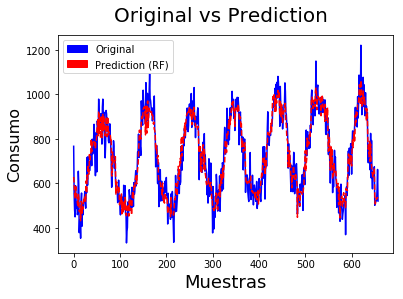

In [47]:
plt.plot(order_labels,'b-',rfOrder_predictions,'r--')
plt.suptitle('Original vs Prediction', fontsize=20)
plt.xlabel('Muestras', fontsize=18)
plt.ylabel('Consumo', fontsize=16)
blue_patch = mpatches.Patch(color='blue', label='Original')
red_patch = mpatches.Patch(color='red', label='Prediction (RF)')
plt.legend(handles=[blue_patch,red_patch])

Como se puede observar, el modelo logra ajustarse bastante bien a la curva original sin sobreajustarse a los valores extremos.

### 3.2.- Support Vector Regression
<a id="svr"></a>

In [48]:
from sklearn.svm import SVR

Como SVR utiliza varios hyper-parámetros para ajsutar el modelo, se utiliza el método de Grid Search para buscar los que produzcan los mejores resultados posibles que consiste básicamente en probar una tupla finita de posibles
valores, luego si es necesario explorar ciertas áreas de menor error con valores en ese rango. Se entrena el SVR, utilizando un kernel radial.
También cabe destacar que se utiliza 10-fold cross validation para la validación del modelo.
Los parámetros a ajustar corresponden a costo, epsilon y gamma y dependiendo de los valores utilizado influirán en cuanto se ajusta el modelo a los datos.
El costo corresponde a una penalización que se le otorga a los puntos de las muestras no separables que se encuentran  en el lado incorrecto del plano, el epsilon define un margen de tolerancia a la penalización alrededor de los vectores de soporte y gamma es un parámetro del kernel radial que regula el radio de área de influencia de los vectores de soporte.

In [49]:
param_grid = {
    'C': [0.25,0.5,1,2,4,8,16,32,64,128,256,512],
    'epsilon': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
    'gamma': [0.625,0.25,0.5,1,2,4,8]
}

In [50]:
svr = SVR()
svrModel = GridSearchCV(estimator = svr, param_grid = param_grid, cv = 10)

In [51]:
svrModel.fit(train_features, train_labels)

GridSearchCV(cv=10, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'epsilon': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 'C': [0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512], 'gamma': [0.625, 0.25, 0.5, 1, 2, 4, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [52]:
svrModel.best_params_

{'C': 512, 'epsilon': 1, 'gamma': 4}

Se realiza la predicción con los mejores parámetros

In [53]:
svrModel = SVR(C=512, epsilon=1, gamma=4)

In [54]:
svrModel.fit(train_features, train_labels)

SVR(C=512, cache_size=200, coef0=0.0, degree=3, epsilon=1, gamma=4,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [55]:
svrPredictions = svrModel.predict(test_features)

In [57]:
errors = abs(svrPredictions - test_labels)

In [58]:
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

('Mean Absolute Error:', 57.31, 'degrees.')


El error obtenido es un poco mayor al de Random Forest

Al igual que en el modelo anterior, se ordenan las predicciones para ver como se ajusta a la curva del conjunto de pruebas

In [60]:
svrOrder_predictions = pd.DataFrame(svrPredictions)
svrOrder_predictions = svrOrder_predictions.loc[order_features.index.values]
svrOrder_predictions.head()

,0
629,640.712507
544,623.987411
433,538.374309
337,524.254724
7,592.575561


In [61]:
svrOrder_predictions = svrOrder_predictions.reset_index(drop=True)
svrOrder_predictions.head()

,0
0,640.712507
1,623.987411
2,538.374309
3,524.254724
4,592.575561


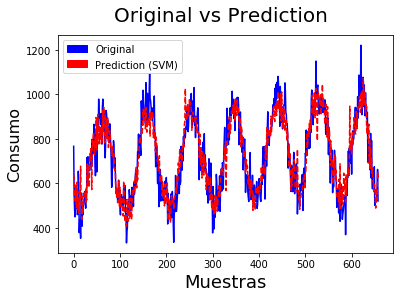

In [62]:
plt.plot(order_labels,'b-',svrOrder_predictions,'r--')
plt.suptitle('Original vs Prediction', fontsize=20)
plt.xlabel('Muestras', fontsize=18)
plt.ylabel('Consumo', fontsize=16)
blue_patch = mpatches.Patch(color='blue', label='Original')
red_patch = mpatches.Patch(color='red', label='Prediction (SVM)')
plt.legend(handles=[blue_patch,red_patch])

Si bien el modelo tiene un poco más de error que el anterior, también se ajusta muy bien a la curva original

### 3.3.- Decision trees
<a id="dl"></a>

In [63]:
from sklearn import tree

In [64]:
dtModel = tree.DecisionTreeClassifier(criterion='gini') 

Este modelo es mucho más sencillo que los anteriores y se utiliza como un punto de comparación. No requiere mayores ajustes en los parámetros por lo que su entrenamiento es bastante rápido.

In [65]:
dtModel.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [66]:
dtPredictions= dtModel.predict(test_features)

In [67]:
errors = abs(dtPredictions - test_labels)

In [68]:
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

('Mean Absolute Error:', 67.98, 'degrees.')


Como era de esperarse resulta el modelo con mayor error.

In [69]:
dtOrder_predictions = pd.DataFrame(dtPredictions)
dtOrder_predictions = dtOrder_predictions.loc[order_features.index.values]
dtOrder_predictions.head()

,0
629,653
544,535
433,470
337,546
7,610


In [70]:
dtOrder_predictions = dtOrder_predictions.reset_index(drop=True)
dtOrder_predictions.head()

,0
0,653
1,535
2,470
3,546
4,610


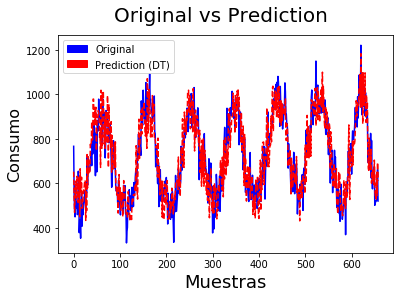

In [71]:
plt.plot(order_labels,'b-',dtOrder_predictions,'r--')
plt.suptitle('Original vs Prediction', fontsize=20)
plt.xlabel('Muestras', fontsize=18)
plt.ylabel('Consumo', fontsize=16)
blue_patch = mpatches.Patch(color='blue', label='Original')
red_patch = mpatches.Patch(color='red', label='Prediction (DT)')
plt.legend(handles=[blue_patch,red_patch])

Si bien muchas lineas escapan de la curva original, aún es visible que la forma de las predicciones se asemejan a esta.

## 4.- Análisis y evaluación de los modelos
<a id="anal"></a>

Los errores obtenidos en regresión no son tan fáciles de interpretar como los de clasificación y por lo general el criterio de selección se realiza a través de una serie de métricas. Las más importantes para evaluar modelos de regresión son las siguientes:

MSE (Mean Squared Error): es el promedio de la diferencia entre los valores originales y los de la predicción.

MAE (Mean Absolute Error): es el promedio de la diferencia en valor absoluto entre el conjunto otriginal y la predicción.

R^2 score: Mide la calidad del modelo para replicar resultados y la proporción de variación de los resultados que puede explicarse por el modelo

RMSE (Root Mean Squared Error): Es una medida de qué tan dispersos o concentrados están los residuos de la línea original o de ajuste

A continuación se define una función para calcular todas estas medidas y evaluar los modelos.

In [72]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2

In [75]:
def calculateErrors(rfPredictions, svrPredictions,dtPredictions, testSet):
    print("\t  RF \t\t-\t\t SVR \t-\t\t DT\n")
    #MSE
    print("MSE:\t %f \t-\t %f \t-\t %f" % (mse(rfPredictions, testSet),mse(svrPredictions, testSet),mse(dtPredictions, testSet)))
    #MAE
    print("MAE:\t %f \t-\t %f \t-\t %f" % (mae(rfPredictions, testSet),mae(svrPredictions, testSet),mae(dtPredictions, testSet)))
    #R2
    print("RF:\t %f \t-\t %f \t-\t %f" % (r2(rfPredictions, testSet),r2(svrPredictions, testSet),r2(dtPredictions, testSet)))

In [76]:
calculateErrors(rfOrder_predictions,svrOrder_predictions,dtOrder_predictions,order_labels)

	  RF 		-		 SVR 	-		 DT

MSE:	 2823.001301 	-	 5352.568422 	-	 7626.651976
MAE:	 42.887347 	-	 57.310739 	-	 67.983283
RF:	 0.896156 	-	 0.788487 	-	 0.744314


En los errores presentados se puede notar que en general el modelo de Random Forest fue el que obtuvo las mejores predicciones y Decision Trees las peores. El caso de estudiar varios errores es debido a que en ocasiones los valores son tan cercanos que se necesita otra medida, por ejemplo si el MAE es igual, el MSE indica cual posee mayor dispersión, o la calidad con el estimador R^2 (cuyo valor máximo es 1). En este caso los errores resultan claramente diferenciables. Aún así para establecer una medida del error obtenido, el más intuitivo corresponde al de MAE que podría definirse como la acumulació del error a lo largo de todas las instancias de la predicción. Si tomamos el mejor modelo (RF), un error de 42 en 657 valores indica que el error promedio es de aproximadamente 0.07 en cada una. Como se menciona anteriormente esta medida no es sensible a la dispersión pero aún así sirve para comprender que tan alta podría ser la pérdida y por tanto que tan riesgoso es el modelo.

Para entregar resultados de mayor impacto para el cliente se pueden usar bibliotecas como plot_ly que permiten interactividad con los datos. En este ejemplo se incluyen sliders para acotar el conjunto de predicciones y botones en la parte superior para fijar ciertas zonas. Además se muestran los valores del consumo al deslizar el mouse por arriba de los valores. 

plot_ly en su verssión básica sólo permite utilizar una reducida cantidad de gráficos utilizando su api en la Web, pero son ilimitados al utilizarlos de forma local, por esto se exhiben imágenes de los resultados obtenidos (de todas formas en el archivo gas.R se encuentra en código para realizar este mismo gráfico ya que la biblioteca esta disponible en ambos lenguajes)

### Ejemplo: Predicciones de valores entre Mayo y Diciembre de 2002

<img src = "img/1.png" height="500" width="500"></img>

Como se puede nota, al poner el cursor sobre cualquier punto se exhiben los valores día a día.

### Predicciones en el rango de una semana

<img src = "img/2.png" height="500" width="500"></img>

(Abajo se puede notar como se ajusta el slider al tiempo deseado)

### Predicciones en el rango de un mes

<img src = "img/3.png" height="500" width="500"></img>

Arriba se pueden encontrar botones (1 mes, 3 meses, 5 meses) que al presionarlos se miden las predicciones deseadas en el gráfico

### Predicciones en el rango de 3 meses

<img src = "img/4.png" height="500" width="500"></img>

### Predicciones en el rango de 5 meses

<img src = "img/5.png" height="500" width="500"></img>

Como conclusión final sólo queda agregar que la efectividad de los modelos puede aumentar en gran medida al agregar más variables y muetras a los datos. En general en comparación SVR y random forest muchas veces logran buenos resultados con un buen ajuste de parámetros, el cual se puede realizar de forma iterativa infinitas veces pero todo depende del tiempo dispuesto para esta tarea en contraste con la tolerancia al error de los resultados. Al ser un conjunto de datos pequeño, probablemente al utilizar random forest con los parámetros por defecto se hubiera llegado a un error similar, en cambio SVR podría tener una mejor oportunidad de crear el mejor modelo en un conjunto con muchas más variables.